In [ ]:
 # relu adam rmse -N
 import pandas as pd
 
data=pd.read_csv('https://api.covid19india.org/csv/latest/case_time_series.csv')
print(data.head())
d=data['Total Confirmed']
d.values

           Date    Date_YMD  ...  Daily Deceased  Total Deceased
0   30 January   2020-01-30  ...               0               0
1   31 January   2020-01-31  ...               0               0
2  01 February   2020-02-01  ...               0               0
3  02 February   2020-02-02  ...               0               0
4  03 February   2020-02-03  ...               0               0

[5 rows x 8 columns]


array([      1,       1,       1,       2,       3,       3,       3,
             3,       3,       3,       3,       3,       3,       3,
             3,       3,       3,       3,       3,       3,       3,
             3,       3,       3,       3,       3,       3,       3,
             3,       3,       3,       3,       5,       6,      28,
            30,      31,      34,      39,      48,      63,      71,
            81,      91,     102,     112,     126,     146,     171,
           198,     256,     334,     403,     497,     571,     657,
           730,     883,    1019,    1139,    1326,    1635,    2059,
          2545,    3105,    3684,    4293,    4777,    5350,    5915,
          6728,    7599,    8453,    9211,   10454,   11485,   12371,
         13432,   14354,   15725,   17305,   18544,   20081,   21373,
         23040,   24448,   26283,   27890,   29458,   31360,   33065,
         34866,   37262,   39826,   42778,   46434,   49405,   53007,
         56351,   59

Optimizer:ADAM
Activation:RELU
Loss:RMSE 

Epoch 1/200
2/2 [==============================] - 0s 58ms/step - loss: 308603092992.0000 - val_loss: 10568510472192.0000
Epoch 2/200
2/2 [==============================] - 0s 9ms/step - loss: 102959841280.0000 - val_loss: 338777374720.0000
Epoch 3/200
2/2 [==============================] - 0s 8ms/step - loss: 11007643648.0000 - val_loss: 3225909198848.0000
Epoch 4/200
2/2 [==============================] - 0s 8ms/step - loss: 10109025280.0000 - val_loss: 10045031972864.0000
Epoch 5/200
2/2 [==============================] - 0s 9ms/step - loss: 36620054528.0000 - val_loss: 12584493252608.0000
Epoch 6/200
2/2 [==============================] - 0s 8ms/step - loss: 44560113664.0000 - val_loss: 10488467423232.0000
Epoch 7/200
2/2 [==============================] - 0s 8ms/step - loss: 31896819712.0000 - val_loss: 6306329001984.0000
Epoch 8/200
2/2 [==============================] - 0s 8ms/step - loss: 13975603200.0000 - val_loss: 2721602338816.0000
Epoch 9/200
2/2 [=========================

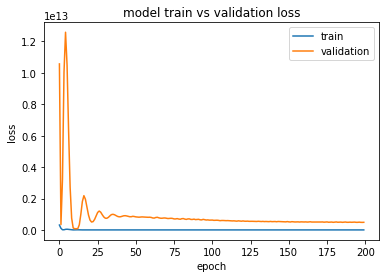

mean rmse value for MLP:  1815530.3542640095
Predicted Next Total Cases In India:  9969411


In [ ]:
 # relu adam rmse -N
 import pandas as pd
 
data=pd.read_csv('https://api.covid19india.org/csv/latest/case_time_series.csv')
data.head()
d=data['Total Confirmed']
d.values
 
 
# evaluate mlp
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]
 
# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values
 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))
 
# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch = config
    # prepare datas
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
 
    # define model
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    history=model.fit(train_x, train_y, epochs=n_epochs,validation_split=0.33, batch_size=n_batch, verbose=1)
    pyplot.plot(history.history['loss'][:])
    pyplot.plot(history.history['val_loss'][:])
    pyplot.title('model train vs validation loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper right')
    pyplot.show()
 
    return model
 
# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _ = config
    # prepare data
    x_input = array(history[-n_input:]).reshape(1, n_input)
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    #print(' > %.3f' % error)
  
    return error,predictions
 
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=1):
    # fit and evaluate the model n times
    scores= [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores
 
 
 
 
data = d.values
# data split
n_test = 12
# define config
config = [24, 500, 200, 110]
# grid search
result= repeat_evaluate(data, config, n_test)
# summarize scores
scores=result[0]
 
print('mean rmse value for MLP: ',mean(scores[0]))
print('Predicted Next Total Cases In India: ',int(scores[1][-1]))

Optimizer:ADAM
Activation:ELU
Loss:RMSE 

Epoch 1/200
2/2 [==============================] - 0s 49ms/step - loss: 274913853440.0000 - val_loss: 6998457319424.0000
Epoch 2/200
2/2 [==============================] - 0s 9ms/step - loss: 77064781824.0000 - val_loss: 93671448576.0000
Epoch 3/200
2/2 [==============================] - 0s 8ms/step - loss: 5005184512.0000 - val_loss: 5434214187008.0000
Epoch 4/200
2/2 [==============================] - 0s 9ms/step - loss: 15799512064.0000 - val_loss: 12180022886400.0000
Epoch 5/200
2/2 [==============================] - 0s 8ms/step - loss: 43644416000.0000 - val_loss: 13222915604480.0000
Epoch 6/200
2/2 [==============================] - 0s 8ms/step - loss: 44147671040.0000 - val_loss: 9554672746496.0000
Epoch 7/200
2/2 [==============================] - 0s 8ms/step - loss: 25219196928.0000 - val_loss: 5318976208896.0000
Epoch 8/200
2/2 [==============================] - 0s 8ms/step - loss: 9530767360.0000 - val_loss: 1997389692928.0000
Epoch 9/200
2/2 [==============================]

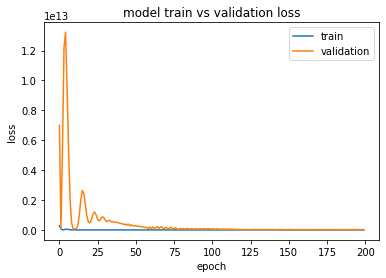

mean rmse value for MLP:  285585.09442976594
Predicted Next Total Cases In India:  8254666


In [ ]:
 # elu adam rmse -N
 import pandas as pd

data=pd.read_csv('https://api.covid19india.org/csv/latest/case_time_series.csv')
data.head()
d=data['Total Confirmed']
d.values


# evaluate mlp
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_nodes, n_epochs, n_batch = config
	# prepare datas
	data = series_to_supervised(train, n_in=n_input)
	train_x, train_y = data[:, :-1], data[:, -1]

	# define model
	model = Sequential()
	model.add(Dense(n_nodes, activation='elu', input_dim=n_input))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	history=model.fit(train_x, train_y, epochs=n_epochs,validation_split=0.33, batch_size=n_batch, verbose=1)
	pyplot.plot(history.history['loss'][:])
	pyplot.plot(history.history['val_loss'][:])
	pyplot.title('model train vs validation loss')
	pyplot.ylabel('loss')
	pyplot.xlabel('epoch')
	pyplot.legend(['train', 'validation'], loc='upper right')
	pyplot.show()

	return model

# forecast with a pre-fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _ = config
	# prepare data
	x_input = array(history[-n_input:]).reshape(1, n_input)
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	#print(' > %.3f' % error)
  
	return error,predictions

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=1):
	# fit and evaluate the model n times
	scores= [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores




data = d.values
# data split
n_test = 12
# define config
config = [24, 500, 200, 110]
# grid search
result= repeat_evaluate(data, config, n_test)
# summarize scores
scores=result[0]

print('mean rmse value for MLP: ',mean(scores[0]))
print('Predicted Next Total Cases In India: ',int(scores[1][-1]))


Optimizer:ADAM
Activation:SELU
Loss:RMSE 

Epoch 1/200
2/2 [==============================] - 0s 41ms/step - loss: 115857547264.0000 - val_loss: 284327149568.0000
Epoch 2/200
2/2 [==============================] - 0s 8ms/step - loss: 11484367872.0000 - val_loss: 4718417412096.0000
Epoch 3/200
2/2 [==============================] - 0s 8ms/step - loss: 12816748544.0000 - val_loss: 11095624384512.0000
Epoch 4/200
2/2 [==============================] - 0s 8ms/step - loss: 35255615488.0000 - val_loss: 9863877885952.0000
Epoch 5/200
2/2 [==============================] - 0s 8ms/step - loss: 26716583936.0000 - val_loss: 5266907594752.0000
Epoch 6/200
2/2 [==============================] - 0s 8ms/step - loss: 9278290944.0000 - val_loss: 1559980146688.0000
Epoch 7/200
2/2 [==============================] - 0s 8ms/step - loss: 511996960.0000 - val_loss: 186132938752.0000
Epoch 8/200
2/2 [==============================] - 0s 8ms/step - loss: 4160844032.0000 - val_loss: 91685822464.0000
Epoch 9/200
2/2 [==============================] - 0s

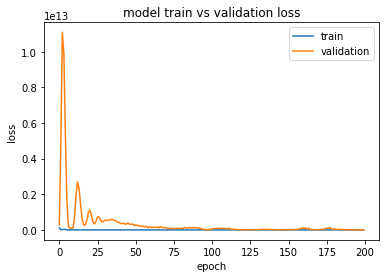

mean rmse value for MLP:  40324.66880288665
Predicted Next Total Cases In India:  7972215


In [ ]:
 # selu adam rmse -N
 import pandas as pd

data=pd.read_csv('https://api.covid19india.org/csv/latest/case_time_series.csv')
data.head()
d=data['Total Confirmed']
d.values


# evaluate mlp
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_nodes, n_epochs, n_batch = config
	# prepare datas
	data = series_to_supervised(train, n_in=n_input)
	train_x, train_y = data[:, :-1], data[:, -1]

	# define model
	model = Sequential()
	model.add(Dense(n_nodes, activation='selu', input_dim=n_input))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	history=model.fit(train_x, train_y, epochs=n_epochs,validation_split=0.33, batch_size=n_batch, verbose=1)
	pyplot.plot(history.history['loss'][:])
	pyplot.plot(history.history['val_loss'][:])
	pyplot.title('model train vs validation loss')
	pyplot.ylabel('loss')
	pyplot.xlabel('epoch')
	pyplot.legend(['train', 'validation'], loc='upper right')
	pyplot.show()

	return model

# forecast with a pre-fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _ = config
	# prepare data
	x_input = array(history[-n_input:]).reshape(1, n_input)
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	#print(' > %.3f' % error)
  
	return error,predictions

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=1):
	# fit and evaluate the model n times
	scores= [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores




data = d.values
# data split
n_test = 12
# define config
config = [24, 500, 200, 110]
# grid search
result= repeat_evaluate(data, config, n_test)
# summarize scores
scores=result[0]

print('mean rmse value for MLP: ',mean(scores[0]))
print('Predicted Next Total Cases In India: ',int(scores[1][-1]))


Optimizer:RMSProp
Activation:SELU
Loss:RMSE 

Epoch 1/200
2/2 [==============================] - 0s 42ms/step - loss: 284361555968.0000 - val_loss: 162826190848.0000
Epoch 2/200
2/2 [==============================] - 0s 8ms/step - loss: 2067887616.0000 - val_loss: 565911486464.0000
Epoch 3/200
2/2 [==============================] - 0s 9ms/step - loss: 480427872.0000 - val_loss: 563795984384.0000
Epoch 4/200
2/2 [==============================] - 0s 9ms/step - loss: 433844000.0000 - val_loss: 377595887616.0000
Epoch 5/200
2/2 [==============================] - 0s 10ms/step - loss: 813845120.0000 - val_loss: 81515143168.0000
Epoch 6/200
2/2 [==============================] - 0s 9ms/step - loss: 3520121344.0000 - val_loss: 475017609216.0000
Epoch 7/200
2/2 [==============================] - 0s 8ms/step - loss: 345784256.0000 - val_loss: 158337875968.0000
Epoch 8/200
2/2 [==============================] - 0s 8ms/step - loss: 1445475328.0000 - val_loss: 48713326592.0000
Epoch 9/200
2/2 [==============================] - 0s 8ms/step - l

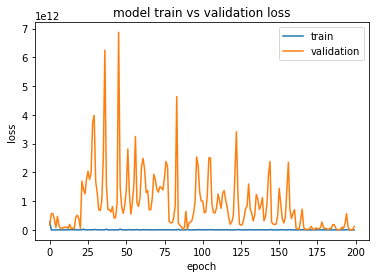

mean rmse value for MLP:  852900.1527655876
Predicted Next Total Cases In India:  6957363


In [ ]:
 # selu RMSProp rmse -N
 import pandas as pd

data=pd.read_csv('https://api.covid19india.org/csv/latest/case_time_series.csv')
data.head()
d=data['Total Confirmed']
d.values


# evaluate mlp
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_nodes, n_epochs, n_batch = config
	# prepare datas
	data = series_to_supervised(train, n_in=n_input)
	train_x, train_y = data[:, :-1], data[:, -1]

	# define model
	model = Sequential()
	model.add(Dense(n_nodes, activation='selu', input_dim=n_input))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='RMSProp')
	# fit
	history=model.fit(train_x, train_y, epochs=n_epochs,validation_split=0.33, batch_size=n_batch, verbose=1)
	pyplot.plot(history.history['loss'][:])
	pyplot.plot(history.history['val_loss'][:])
	pyplot.title('model train vs validation loss')
	pyplot.ylabel('loss')
	pyplot.xlabel('epoch')
	pyplot.legend(['train', 'validation'], loc='upper right')
	pyplot.show()

	return model

# forecast with a pre-fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _ = config
	# prepare data
	x_input = array(history[-n_input:]).reshape(1, n_input)
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	#print(' > %.3f' % error)
  
	return error,predictions

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=1):
	# fit and evaluate the model n times
	scores= [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores




data = d.values
# data split
n_test = 12
# define config
config = [24, 500, 200, 110]
# grid search
result= repeat_evaluate(data, config, n_test)
# summarize scores
scores=result[0]

print('mean rmse value for MLP: ',mean(scores[0]))
print('Predicted Next Total Cases In India: ',int(scores[1][-1]))


Optimizer:ADADELTA
Activation:SELU
Loss:RMSE 

Epoch 1/200
2/2 [==============================] - 0s 43ms/step - loss: 232537505792.0000 - val_loss: 24453572460544.0000
Epoch 2/200
2/2 [==============================] - 0s 8ms/step - loss: 232180744192.0000 - val_loss: 24406571089920.0000
Epoch 3/200
2/2 [==============================] - 0s 8ms/step - loss: 231810105344.0000 - val_loss: 24362516217856.0000
Epoch 4/200
2/2 [==============================] - 0s 8ms/step - loss: 231449919488.0000 - val_loss: 24317047865344.0000
Epoch 5/200
2/2 [==============================] - 0s 8ms/step - loss: 231088898048.0000 - val_loss: 24273901060096.0000
Epoch 6/200
2/2 [==============================] - 0s 8ms/step - loss: 230729203712.0000 - val_loss: 24227455434752.0000
Epoch 7/200
2/2 [==============================] - 0s 8ms/step - loss: 230350700544.0000 - val_loss: 24180728791040.0000
Epoch 8/200
2/2 [==============================] - 0s 8ms/step - loss: 229967757312.0000 - val_loss: 24133079400448.0000
Epoch 9/200
2/2 [==============

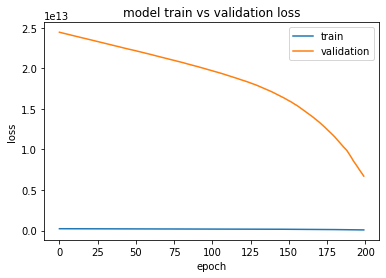

mean rmse value for MLP:  4004772.425425249
Predicted Next Total Cases In India:  3852910


In [ ]:
 # selu adadelta rmse -N
 import pandas as pd

data=pd.read_csv('https://api.covid19india.org/csv/latest/case_time_series.csv')
data.head()
d=data['Total Confirmed']
d.values


# evaluate mlp
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_nodes, n_epochs, n_batch = config
	# prepare datas
	data = series_to_supervised(train, n_in=n_input)
	train_x, train_y = data[:, :-1], data[:, -1]

	# define model
	model = Sequential()
	model.add(Dense(n_nodes, activation='selu', input_dim=n_input))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adadelta')
	# fit
	history=model.fit(train_x, train_y, epochs=n_epochs,validation_split=0.33, batch_size=n_batch, verbose=1)
	pyplot.plot(history.history['loss'][:])
	pyplot.plot(history.history['val_loss'][:])
	pyplot.title('model train vs validation loss')
	pyplot.ylabel('loss')
	pyplot.xlabel('epoch')
	pyplot.legend(['train', 'validation'], loc='upper right')
	pyplot.show()

	return model

# forecast with a pre-fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _ = config
	# prepare data
	x_input = array(history[-n_input:]).reshape(1, n_input)
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	#print(' > %.3f' % error)
  
	return error,predictions

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=1):
	# fit and evaluate the model n times
	scores= [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores




data = d.values
# data split
n_test = 12
# define config
config = [24, 500, 200, 110]
# grid search
result= repeat_evaluate(data, config, n_test)
# summarize scores
scores=result[0]

print('mean rmse value for MLP: ',mean(scores[0]))
print('Predicted Next Total Cases In India: ',int(scores[1][-1]))


Optimizer:ADAM
Activation:SELU
Loss:RMSE 

with nbatch=110

Epoch 1/100
2/2 [==============================] - 0s 41ms/step - loss: 206675296256.0000 - val_loss: 2565670961152.0000
Epoch 2/100
2/2 [==============================] - 0s 8ms/step - loss: 39132938240.0000 - val_loss: 1736607531008.0000
Epoch 3/100
2/2 [==============================] - 0s 8ms/step - loss: 3428395264.0000 - val_loss: 10013796990976.0000
Epoch 4/100
2/2 [==============================] - 0s 8ms/step - loss: 29346789376.0000 - val_loss: 13648257875968.0000
Epoch 5/100
2/2 [==============================] - 0s 8ms/step - loss: 41479372800.0000 - val_loss: 10721348812800.0000
Epoch 6/100
2/2 [==============================] - 0s 9ms/step - loss: 27652491264.0000 - val_loss: 5621875736576.0000
Epoch 7/100
2/2 [==============================] - 0s 8ms/step - loss: 7390012928.0000 - val_loss: 1927703429120.0000
Epoch 8/100
2/2 [==============================] - 0s 8ms/step - loss: 473070528.0000 - val_loss: 344115838976.0000
Epoch 9/100
2/2 [==============================]

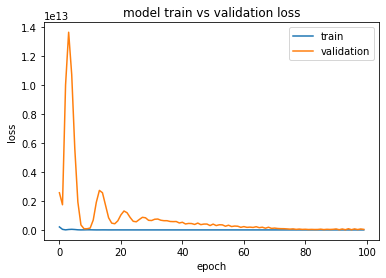

mean rmse value for MLP:  396490.96357735567
Predicted Next Total Cases In India:  8373458


In [ ]:
 # selu adam rmse -N
 import pandas as pd

data=pd.read_csv('https://api.covid19india.org/csv/latest/case_time_series.csv')
data.head()
d=data['Total Confirmed']
d.values


# evaluate mlp
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_nodes, n_epochs, n_batch = config
	# prepare datas
	data = series_to_supervised(train, n_in=n_input)
	train_x, train_y = data[:, :-1], data[:, -1]

	# define model
	model = Sequential()
	model.add(Dense(n_nodes, activation='selu', input_dim=n_input))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	history=model.fit(train_x, train_y, epochs=n_epochs,validation_split=0.33, batch_size=n_batch, verbose=1)
	pyplot.plot(history.history['loss'][:])
	pyplot.plot(history.history['val_loss'][:])
	pyplot.title('model train vs validation loss')
	pyplot.ylabel('loss')
	pyplot.xlabel('epoch')
	pyplot.legend(['train', 'validation'], loc='upper right')
	pyplot.show()

	return model

# forecast with a pre-fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _ = config
	# prepare data
	x_input = array(history[-n_input:]).reshape(1, n_input)
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	#print(' > %.3f' % error)
  
	return error,predictions

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=1):
	# fit and evaluate the model n times
	scores= [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores




data = d.values
# data split
n_test = 12
# define config
config = [24, 500, 100, 110]
# grid search
result= repeat_evaluate(data, config, n_test)
# summarize scores
scores=result[0]

print('mean rmse value for MLP: ',mean(scores[0]))
print('Predicted Next Total Cases In India: ',int(scores[1][-1]))


COMPARISION OF MLP WITH BASE PAPER POLYNOMIAL REGRESSION RESULTS

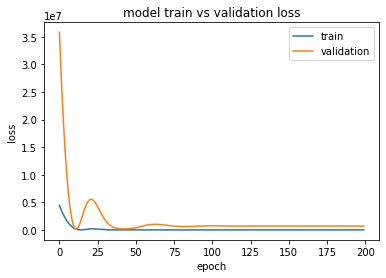

mean rmse value for MLP:  3434.269529686943
The predicted cases:
The predicted cases for 12 April: [10229.924]
The predicted cases for 13 April: [11654.458]
The predicted cases for 14 April: [13166.432]
The predicted cases for 15 April: [14967.009]
The predicted cases for 16 April: [17000.627]
The predicted cases for 17 April: [19170.205]
The predicted cases for 18 April: [21382.135]
Predicted Next Total Cases In India:  21382


In [ ]:
 # selu adam rmse -N
 import pandas as pd

dataTrain=pd.read_csv('trainBPpdf.csv')
dataTest=pd.read_csv('testBPpdf.csv')

dTrain=dataTrain['Total Confirmed']
dTest=dataTest['Total Confirmed']



# evaluate mlp
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
# split a univariate dataset into train/test sets

# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_nodes, n_epochs, n_batch = config
	# prepare datas
	data = series_to_supervised(train, n_in=n_input)
	train_x, train_y = data[:, :-1], data[:, -1]

	# define model
	model = Sequential()
	model.add(Dense(n_nodes, activation='selu', input_dim=n_input))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	history=model.fit(train_x, train_y, epochs=n_epochs,validation_split=0.33, batch_size=n_batch, verbose=0)
	pyplot.plot(history.history['loss'][:])
	pyplot.plot(history.history['val_loss'][:])
	pyplot.title('model train vs validation loss')
	pyplot.ylabel('loss')
	pyplot.xlabel('epoch')
	pyplot.legend(['train', 'validation'], loc='upper right')
	pyplot.show()

	return model

# forecast with a pre-fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _ = config
	# prepare data
	x_input = array(history[-n_input:]).reshape(1, n_input)
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(dTrain,dTest,cfg):
	predictions = list()
	# split dataset
	train, test =dTrain, dTest
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	#print(' > %.3f' % error)
  
	return error,predictions

# repeat evaluation of a config
def repeat_evaluate(dTrain,dTest,config,n_repeats=1):
	# fit and evaluate the model n times
	scores= [walk_forward_validation(dTrain,dTest,config) for _ in range(n_repeats)]
	return scores





# define config
config = [24, 500, 200, 110]
# grid search
result= repeat_evaluate(dTrain,dTest,config)
# summarize scores
scores=result[0]

print('mean rmse value for MLP: ',mean(scores[0]))
print('The predicted cases:')
c=0
for i in range(12,19):
  print(f'The predicted cases for {i} April:',scores[1][c])
  c+=1

print('Predicted Next Total Cases In India: ',int(scores[1][-1]))


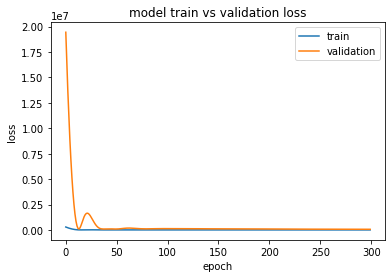

mean rmse value for MLP:  1419.2135647610726
The predicted cases:
The predicted cases for 12 April: [9253.312]
The predicted cases for 13 April: [10297.771]
The predicted cases for 14 April: [11689.916]
The predicted cases for 15 April: [13331.459]
The predicted cases for 16 April: [14939.374]
The predicted cases for 17 April: [16061.805]
The predicted cases for 18 April: [17444.592]
Predicted Next Total Cases In India:  17444


In [ ]:
 # selu adam rmse -N
 import pandas as pd

dataTrain=pd.read_csv('trainBPpdf.csv')
dataTest=pd.read_csv('testBPpdf.csv')

dTrain=dataTrain['Total Confirmed']
dTest=dataTest['Total Confirmed']



# evaluate mlp
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
# split a univariate dataset into train/test sets

# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_nodes, n_epochs, n_batch = config
	# prepare datas
	data = series_to_supervised(train, n_in=n_input)
	train_x, train_y = data[:, :-1], data[:, -1]

	# define model
	model = Sequential()
	model.add(Dense(n_nodes, activation='selu', input_dim=n_input))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	history=model.fit(train_x, train_y, epochs=n_epochs,validation_split=0.33, batch_size=n_batch, verbose=0)
	pyplot.plot(history.history['loss'][:])
	pyplot.plot(history.history['val_loss'][:])
	pyplot.title('model train vs validation loss')
	pyplot.ylabel('loss')
	pyplot.xlabel('epoch')
	pyplot.legend(['train', 'validation'], loc='upper right')
	pyplot.show()

	return model

# forecast with a pre-fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _ = config
	# prepare data
	x_input = array(history[-n_input:]).reshape(1, n_input)
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(dTrain,dTest,cfg):
	predictions = list()
	# split dataset
	train, test =dTrain, dTest
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	#print(' > %.3f' % error)
  
	return error,predictions

# repeat evaluation of a config
def repeat_evaluate(dTrain,dTest,config,n_repeats=1):
	# fit and evaluate the model n times
	scores= [walk_forward_validation(dTrain,dTest,config) for _ in range(n_repeats)]
	return scores





# define config
config = [8, 500, 300, 150]
# grid search
result= repeat_evaluate(dTrain,dTest,config)
# summarize scores
scores=result[0]

print('mean rmse value for MLP: ',mean(scores[0]))
print('The predicted cases:')
c=0
for i in range(12,19):
  print(f'The predicted cases for {i} April:',scores[1][c])
  c+=1

print('Predicted Next Total Cases In India: ',int(scores[1][-1]))


test with new config

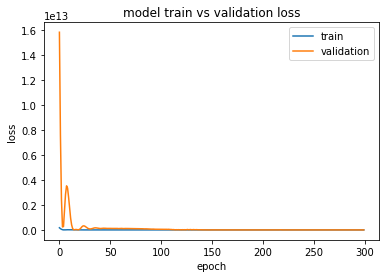

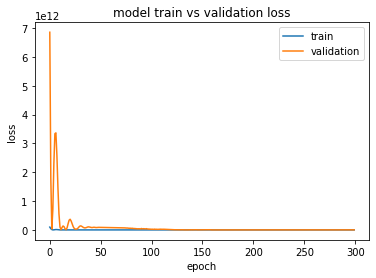

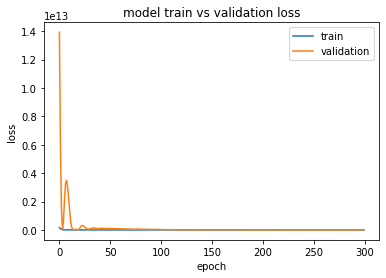

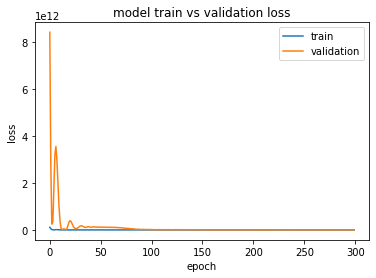

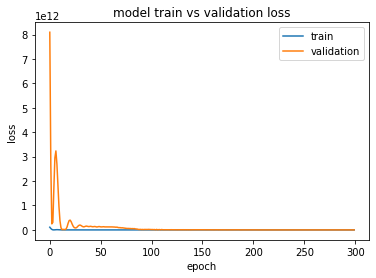

mean rmse value for MLP:  12601.475643583704
Predicted Next Total Cases In India:  7895339


In [ ]:
 # selu adam rmse -N
 import pandas as pd

data=pd.read_csv('https://api.covid19india.org/csv/latest/case_time_series.csv')
data.head()
d=data['Total Confirmed']
d.values


# evaluate mlp
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_nodes, n_epochs, n_batch = config
	# prepare datas
	data = series_to_supervised(train, n_in=n_input)
	train_x, train_y = data[:, :-1], data[:, -1]

	# define model
	model = Sequential()
	model.add(Dense(n_nodes, activation='selu', input_dim=n_input))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	history=model.fit(train_x, train_y, epochs=n_epochs,validation_split=0.33, batch_size=n_batch, verbose=0)
	pyplot.plot(history.history['loss'][:])
	pyplot.plot(history.history['val_loss'][:])
	pyplot.title('model train vs validation loss')
	pyplot.ylabel('loss')
	pyplot.xlabel('epoch')
	pyplot.legend(['train', 'validation'], loc='upper right')
	pyplot.show()

	return model

# forecast with a pre-fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _ = config
	# prepare data
	x_input = array(history[-n_input:]).reshape(1, n_input)
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	#print(' > %.3f' % error)
  
	return error,predictions

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=5):
	# fit and evaluate the model n times
	scores= [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores




data = d.values
# data split
n_test = 12
# define config
config = [8, 500, 300, 110]
# grid search
result= repeat_evaluate(data, config, n_test)
# summarize scores
scores=result[0]

print('mean rmse value for MLP: ',mean(scores[0]))
print('Predicted Next Total Cases In India: ',int(scores[1][-1]))
